In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
loans=pd.read_csv(r"C:\Users\divyam.arora\Desktop\New Folder 3\machine-learning-specialization-master\course-3\datasets\lending-club-data.csv",sep=',',low_memory=False)

In [85]:
features = ['grade',              # grade of the loan
            'term',               # the term of the loan
            'home_ownership',     # home ownership status: own, mortgage or rent
            'emp_length',         # number of years of employment
           ]
loans['safe_loans'] = loans['bad_loans'].apply(lambda x : +1 if x==0 else -1)
target = 'safe_loans'
loans = loans[features + [target]]

In [86]:
loans=loans[loans['home_ownership']!='OTHER']
total_loans=loans[loans['safe_loans']==1]
risky_loans=loans[loans['safe_loans']==-1]
total_loans=total_loans.sample(frac=(len(risky_loans)/len(total_loans)),random_state=1)
total_loans=total_loans.append(risky_loans)

In [87]:
total_loans=pd.get_dummies(total_loans, columns=["home_ownership"])
total_loans=pd.get_dummies(total_loans, columns=["term"])
total_loans=pd.get_dummies(total_loans, columns=["emp_length"])
total_loans=pd.get_dummies(total_loans, columns=["grade"])
train_data,test_data=train_test_split(total_loans,test_size=0.2,random_state=2)

In [88]:
#Weighted Descision Tree 
def intermediate_node_weighted_mistakes(labels_in_node, data_weights):
    # Sum the weights of all entries with label +1
    #total_weight_positive = sum(data_weights[labels_in_node == +1])
    row_index = labels_in_node == 1
    print(data_weights)
    data_weights.index=labels_in_node.index
    print(data_weights)
    total_weight_positive=sum(data_weights.loc[row_index])
    
    # Weight of mistakes for predicting all -1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_negative = total_weight_positive
    
    # Sum the weights of all entries with label -1
    ### YOUR CODE HERE
    row_index = labels_in_node == -1
    total_weight_negative=sum(data_weights.loc[row_index])
    #total_weight_negative = sum(data_weights[labels_in_node == -1])
    
    # Weight of mistakes for predicting all +1's is equal to the sum above
    ### YOUR CODE HERE
    weighted_mistakes_all_positive = total_weight_negative
    
    # Return the tuple (weight, class_label) representing the lower of the two weights
    #    class_label should be an integer of value +1 or -1.
    # If the two weights are identical, return (weighted_mistakes_all_positive,+1)
    ### YOUR CODE HERE
    if weighted_mistakes_all_negative==weighted_mistakes_all_positive:
        return (weighted_mistakes_all_positive,+1)
    if weighted_mistakes_all_negative>weighted_mistakes_all_positive:
        return (weighted_mistakes_all_positive,+1)
    
    return (weighted_mistakes_all_negative,-1)

In [89]:
example_labels = pd.Series([-1, -1, 1, 1, 1])
example_data_weights = pd.Series([1., 2., .5, 1., 1.])
if intermediate_node_weighted_mistakes(example_labels, example_data_weights) == (2.5, -1):
    print('Test passed!')
else:
    print('Test failed... try again!')

Test passed!


In [90]:
#selecting the best feature to split on
def best_splitting_feature(data, features, target, data_weights):
    
    # These variables will keep track of the best feature and the corresponding error
    best_feature = None
    best_error = float('+inf') 
    num_points = float(len(data))
    total_weights_of_all_points = sum(data_weights)

    # Loop through each feature to consider splitting on that feature
    for feature in features:
        
        # The left split will have all data points where the feature value is 0
        # The right split will have all data points where the feature value is 1
        left_split = data[data[feature] == 0]
        right_split = data[data[feature] == 1]
        
        # Apply the same filtering to data_weights to create left_data_weights, right_data_weights
        ## YOUR CODE HERE
        left_data_weights = data_weights[data[feature] == 0]
        right_data_weights = data_weights[data[feature] == 1]
                    
        # DIFFERENT HERE
        # Calculate the weight of mistakes for left and right sides
        ## YOUR CODE HERE
        left_weighted_mistakes, left_class = intermediate_node_weighted_mistakes(left_split[target], left_data_weights)
        right_weighted_mistakes, right_class = intermediate_node_weighted_mistakes(right_split[target], right_data_weights)
        
        # DIFFERENT HERE
        # Compute weighted error by computing
        #  ( [weight of mistakes (left)] + [weight of mistakes (right)] ) / [total weight of all data points]
        ## YOUR CODE HERE
        error = ((left_weighted_mistakes+right_weighted_mistakes)/total_weights_of_all_points)
        
        # If this is the best error we have found so far, store the feature and the error
        if error < best_error:
            best_feature = feature
            best_error = error
    
    # Return the best feature we found
    return best_feature

In [91]:
feature_Set=total_loans.columns.tolist()
feature_Set.remove('safe_loans')

In [92]:
train_data['weights'] = 1.5
train_features=train_data.columns.tolist()
train_features.remove('weights')

D:\python\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [93]:
if best_splitting_feature(train_data[train_features], feature_Set, target, train_data['weights']) == 'term_ 36 months':
    print('Test passed!')
else:
    print('Test failed... try again!')

Test passed!


In [94]:
#Building Tree
def create_leaf(target_values, data_weights):
    
    # Create a leaf node
    leaf = {'splitting_feature' : None,
            'left' : None,
            'right' : None,
            'prediction':None,
            'is_leaf': True}
    
    # Computed weight of mistakes.
    weighted_error, best_class = intermediate_node_weighted_mistakes(target_values, data_weights)
    # Store the predicted class (1 or -1) in leaf['prediction']
    leaf['prediction'] = best_class
    
    return leaf

In [95]:
def weighted_decision_tree_create(data, features, target, data_weights, current_depth = 1, max_depth = 10):
    remaining_features = features[:] # Make a copy of the features.
    target_values = data[target]
    print("--------------------------------------------------------------------")
    print("Subtree, depth = %s (%s data points)." % (current_depth, len(target_values)))
    
    # Stopping condition 1. Error is 0.
    if intermediate_node_weighted_mistakes(target_values, data_weights)[0] <= 1e-15:
        print("Stopping condition 1 reached.")                
        return create_leaf(target_values, data_weights)
    
    # Stopping condition 2. No more features.
    if remaining_features == []:
        print("Stopping condition 2 reached.")                
        return create_leaf(target_values, data_weights)    
    
    # Additional stopping condition (limit tree depth)
    if current_depth > max_depth:
        print("Reached maximum depth. Stopping for now.")
        return create_leaf(target_values, data_weights)
    
    splitting_feature = best_splitting_feature(data, features, target, data_weights)
    print('removing feature:',splitting_feature)
    remaining_features.remove(splitting_feature)
        
    left_split = data[data[splitting_feature] == 0]
    right_split = data[data[splitting_feature] == 1]
    
    left_data_weights = data_weights[data[splitting_feature] == 0]
    right_data_weights = data_weights[data[splitting_feature] == 1]
    
    print("Split on feature %s. (%s, %s)" % (\
              splitting_feature, len(left_split), len(right_split)))
    
    # Create a leaf node if the split is "perfect"
    if len(left_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(left_split[target], data_weights)
    if len(right_split) == len(data):
        print("Creating leaf node.")
        return create_leaf(right_split[target], data_weights)
    
    # Repeat (recurse) on left and right subtrees
    left_tree = weighted_decision_tree_create(
        left_split, remaining_features, target, left_data_weights, current_depth + 1, max_depth)
    right_tree = weighted_decision_tree_create(
        right_split, remaining_features, target, right_data_weights, current_depth + 1, max_depth)
    
    return {'is_leaf'          : False, 
            'prediction'       : None,
            'splitting_feature': splitting_feature,
            'left'             : left_tree, 
            'right'            : right_tree}

In [96]:
def count_nodes(tree):
    if tree['is_leaf']:
        return 1
    return 1 + count_nodes(tree['left']) + count_nodes(tree['right'])

In [11]:
feature_set=train_data.columns.tolist()
feature_set.remove('safe_loans')
#feature_set.remove('weights')

In [98]:
train_data[feature_set].columns

Index(['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT',
       'term_ 36 months', 'term_ 60 months', 'emp_length_1 year',
       'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years',
       'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years',
       'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years',
       'emp_length_< 1 year', 'emp_length_n/a', 'grade_A', 'grade_B',
       'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G'],
      dtype='object')

In [99]:
train_data['weights'] = 1.0
small_data_decision_tree = weighted_decision_tree_create(train_data, feature_set, target,train_data['weights'], max_depth=2)
if count_nodes(small_data_decision_tree) == 7:
    print('Test passed!')
else:
    print('Test failed... try again!')
    print('Number of nodes found:', count_nodes(small_data_decision_tree))
    print('Number of nodes that should be there: 7' )

D:\python\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


--------------------------------------------------------------------
Subtree, depth = 1 (36974 data points).
removing feature: term_ 36 months
Split on feature term_ 36 months. (9362, 27612)
--------------------------------------------------------------------
Subtree, depth = 2 (9362 data points).
removing feature: grade_A
Split on feature grade_A. (9240, 122)
--------------------------------------------------------------------
Subtree, depth = 3 (9240 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (122 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (27612 data points).
removing feature: grade_D
Split on feature grade_D. (23034, 4578)
--------------------------------------------------------------------
Subtree, depth = 3 (23034 data points).
Reached maximum depth. Stopping for now.
---------------

In [100]:
def classify(tree, x, annotate = False):   
    # If the node is a leaf node.
    if tree['is_leaf']:
        if annotate: 
            print("At leaf, predicting %s" % tree['prediction'])
        return tree['prediction'] 
    else:
        # Split on feature.
        split_feature_value = x.head(1)[tree['splitting_feature']].values[0]
        if annotate: 
            print("Split on %s = %s" % (tree['splitting_feature'], split_feature_value))
        if split_feature_value == 0:
            return classify(tree['left'], x, annotate)
        else:
            return classify(tree['right'], x, annotate)

In [101]:
def evaluate_classification_error(tree, data):
    # Apply the classify(tree, x) to each row in your data
    prediction = data.apply(lambda x: classify(tree, pd.DataFrame(x).transpose()),axis=1)
    
    # Once you've made the predictions, calculate the classification error
    return (prediction != data[target]).sum() / float(len(data))

In [102]:
evaluate_classification_error(small_data_decision_tree, test_data)

0.39539160536564261

In [14]:

start=10
end=len(train_data)-10
for i in range(0,len(train_data)):
    if i<start or i>end:
        #0-9
        train_data.ix[i,('weights')]=1.0
    else:
        train_data.ix[i,('weights')]=0.0
        

D:\python\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [104]:
small_data_decision_tree_subset_20 = weighted_decision_tree_create(train_data, feature_set, target,train_data['weights'], max_depth=2)

--------------------------------------------------------------------
Subtree, depth = 1 (36974 data points).
removing feature: grade_A
Split on feature grade_A. (31818, 5156)
--------------------------------------------------------------------
Subtree, depth = 2 (31818 data points).
removing feature: emp_length_4 years
Split on feature emp_length_4 years. (29564, 2254)
--------------------------------------------------------------------
Subtree, depth = 3 (29564 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 3 (2254 data points).
Stopping condition 1 reached.
--------------------------------------------------------------------
Subtree, depth = 2 (5156 data points).
Stopping condition 1 reached.


In [103]:
train_data.weights=0.0
train_data.head(10).weights=1.0
train_data.tail(10).weights=1.0

D:\python\lib\site-packages\pandas\core\generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [42]:
#The issue here is that: df.col1[df.col1 == 10] returns a copy.

#So I would say:

#row_index = df.col1 == 10
# then with the form .loc[row_indexer,col_indexer]
#df.loc[row_index, 'col1'] = 100
row_index = labels_in_node == 1
total_weight_positive=sum(data_weights.loc[row_index,:])
total_weight_positive = sum(data_weights[labels_in_node == +1])

In [ ]:
evaluate_classification_error(small_data_decision_tree_subset_20,train_data[feat])

In [27]:
feat=train_data.columns.tolist()
feat.remove('weights')

In [29]:
subset_20 = train_data.head(10).append(train_data.tail(10))

In [30]:
evaluate_classification_error(small_data_decision_tree_subset_20, subset_20[feat])

0.5

In [106]:
#IMPLEMENTATION OF ADABOOST(ON DECISION STUMPS)
#MODIFYING WEIGHTED DECISION TREE TO MAKE ADABOOST
from math import log
from math import exp
#features-list of features not containing output label and weights
#data-dataframe of features and output var without weights
#data-dataframe with binary features
#num_tree_stumps- no of tree stumps to train for the ensemble
#it should return list of tree stumps along with list of corresponding tree stumps weights 
#i.e list(f(x)) and list(w-cap)
def adaboost_with_tree_stumps(data, features, target, num_tree_stumps):
    # start with unweighted data
    alpha = pd.Series([1.]*len(data))
    weights = []
    tree_stumps = []
    target_values = data[target]
    
    for t in range(num_tree_stumps):
        print('=====================================================')
        print('Adaboost Iteration %d' % t)
        print('=====================================================')        
        # Learn a weighted decision tree stump. Use max_depth=1
        print('features left:',features)
        tree_stump = weighted_decision_tree_create(data, features, target, data_weights=alpha, max_depth=1)
        tree_stumps.append(tree_stump)
        
        # Make predictions
        #predictions = data.apply(lambda x: classify(tree_stump, x))
        predictions = data.apply(lambda x: classify(tree_stump, pd.DataFrame(x).transpose()),axis=1)
        
        # Produce a Boolean array indicating whether
        # each data point was correctly classified
        #this is the way condition like 
        #equating two series and storing their comparison into new series result
        is_correct = predictions == target_values
        is_wrong   = predictions != target_values
        
        # Compute weighted error
        # YOUR CODE HERE
        weighted_error = sum(alpha[is_wrong])/sum(alpha)
        
        # Compute model coefficient using weighted error
        # YOUR CODE HERE
        weight = 0.5*log((1-weighted_error)/weighted_error)
        weights.append(weight)
        
        # Adjust weights on data point
        adjustment = is_correct.apply(lambda is_correct : exp(-weight) if is_correct else exp(weight))
        
        # Scale alpha by multiplying by adjustment 
        # Then normalize data points weights
        ## YOUR CODE HERE 
        alpha=alpha*adjustment
        sum_of_alpha=sum(alpha)
        alpha=(alpha/sum_of_alpha)
    
    return weights, tree_stumps

In [109]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data[feature], feat, target, num_tree_stumps=2)

Adaboost Iteration 0
features left: ['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'term_ 36 months', 'term_ 60 months', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'emp_length_n/a', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
--------------------------------------------------------------------
Subtree, depth = 1 (36974 data points).
removing feature: term_ 36 months
Split on feature term_ 36 months. (9362, 27612)
--------------------------------------------------------------------
Subtree, depth = 2 (9362 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (27612 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
fea

In [107]:
feature=train_data.columns.tolist()
feature.remove('weights')

In [40]:
feat.remove(target)

In [108]:
feat

['home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'term_ 36 months',
 'term_ 60 months',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'emp_length_n/a',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G']

In [110]:
def print_stump(tree):
    split_name = tree['splitting_feature'] # split_name is something like 'term. 36 months'
    if split_name is None:
        print("(leaf, label: %s)" % tree['prediction'])
        return None
    split_feature, split_value = split_name.split('_')
    print('                       root')
    print('         |---------------|----------------|')
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('  [{0} == 0]{1}[{0} == 1]    '.format(split_name, ' '*(27-len(split_name))))
    print('         |                                |')
    print('         |                                |')
    print('         |                                |')
    print('    (%s)                 (%s)' \
        % (('leaf, label: ' + str(tree['left']['prediction']) if tree['left']['is_leaf'] else 'subtree'),
           ('leaf, label: ' + str(tree['right']['prediction']) if tree['right']['is_leaf'] else 'subtree')))

In [111]:
print_stump(tree_stumps[0])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [term_ 36 months == 0]            [term_ 36 months == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [112]:
print_stump(tree_stumps[1])

                       root
         |---------------|----------------|
         |                                |
         |                                |
         |                                |
  [grade_A == 0]                    [grade_A == 1]    
         |                                |
         |                                |
         |                                |
    (leaf, label: -1)                 (leaf, label: 1)


In [113]:
print(stump_weights)

[0.1532965183687395, 0.1803897469998215]


In [114]:
feature=train_data.columns.tolist()
feature.remove('weights')
feature

['safe_loans',
 'home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'term_ 36 months',
 'term_ 60 months',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'emp_length_n/a',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G']

In [115]:
feat

['home_ownership_MORTGAGE',
 'home_ownership_OWN',
 'home_ownership_RENT',
 'term_ 36 months',
 'term_ 60 months',
 'emp_length_1 year',
 'emp_length_10+ years',
 'emp_length_2 years',
 'emp_length_3 years',
 'emp_length_4 years',
 'emp_length_5 years',
 'emp_length_6 years',
 'emp_length_7 years',
 'emp_length_8 years',
 'emp_length_9 years',
 'emp_length_< 1 year',
 'emp_length_n/a',
 'grade_A',
 'grade_B',
 'grade_C',
 'grade_D',
 'grade_E',
 'grade_F',
 'grade_G']

In [116]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data[feature], feat, 
                                target, num_tree_stumps=10)

Adaboost Iteration 0
features left: ['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'term_ 36 months', 'term_ 60 months', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'emp_length_n/a', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
--------------------------------------------------------------------
Subtree, depth = 1 (36974 data points).
removing feature: term_ 36 months
Split on feature term_ 36 months. (9362, 27612)
--------------------------------------------------------------------
Subtree, depth = 2 (9362 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (27612 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
fea

In [145]:
def predict_adaboost(stump_weights, tree_stumps, data):
    scores = pd.Series([0.]*len(data))
    
    for i, tree_stump in enumerate(tree_stumps):
        predictions = data.apply(lambda x: classify(tree_stump, pd.DataFrame(x).transpose()),axis=1)
        # Accumulate predictions on scores array
        weighted_predictions=predictions*stump_weights[i]
        scores.add(weighted_predictions)
        
    return scores.apply(lambda score : +1 if score > 0 else -1)

In [118]:
from sklearn import metrics

In [137]:
predictions = predict_adaboost(stump_weights, tree_stumps, test_data[feat])
accuracy =metrics.accuracy_score(test_data[target], predictions)
print('Accuracy of 10-component ensemble = %s' % accuracy)

i: 0
Current weight: 0.1532965183687395
predictions: 90302     1
67600     1
56593     1
71050     1
87945     1
32181     1
102229    1
28065     1
59052     1
100232    1
103485    1
20667    -1
90075    -1
80909     1
116067    1
28541     1
91982    -1
10912     1
90437    -1
102273   -1
83437    -1
50933    -1
5340      1
66286     1
2562     -1
25635     1
95422    -1
64077    -1
79144     1
38628     1
         ..
82009    -1
98236    -1
37376     1
41611     1
45520     1
108278    1
45386     1
40853     1
99124     1
18777     1
52146     1
19807    -1
77313     1
4431      1
47318     1
57027     1
82748    -1
36992     1
62996     1
83275     1
88341     1
120452    1
79430    -1
31155     1
80844     1
79481     1
76450    -1
86574     1
40746     1
2926      1
dtype: int64
new predictions: 90302     0.153297
67600     0.153297
56593     0.153297
71050     0.153297
87945     0.153297
32181     0.153297
102229    0.153297
28065     0.153297
59052     0.153297
100232    0.15

In [138]:
stump_weights

[0.1532965183687395,
 0.1803897469998215,
 0.09217844201726134,
 0.06952412978673138,
 0.06600932354604311,
 0.06483544539800329,
 0.054271192186415,
 0.04256117212878792,
 0.028245348723977135,
 0.02085020224158523]

In [142]:
stump_weights, tree_stumps = adaboost_with_tree_stumps(train_data[feature], 
                                 feat, target, num_tree_stumps=30)

Adaboost Iteration 0
features left: ['home_ownership_MORTGAGE', 'home_ownership_OWN', 'home_ownership_RENT', 'term_ 36 months', 'term_ 60 months', 'emp_length_1 year', 'emp_length_10+ years', 'emp_length_2 years', 'emp_length_3 years', 'emp_length_4 years', 'emp_length_5 years', 'emp_length_6 years', 'emp_length_7 years', 'emp_length_8 years', 'emp_length_9 years', 'emp_length_< 1 year', 'emp_length_n/a', 'grade_A', 'grade_B', 'grade_C', 'grade_D', 'grade_E', 'grade_F', 'grade_G']
--------------------------------------------------------------------
Subtree, depth = 1 (36974 data points).
removing feature: term_ 36 months
Split on feature term_ 36 months. (9362, 27612)
--------------------------------------------------------------------
Subtree, depth = 2 (9362 data points).
Reached maximum depth. Stopping for now.
--------------------------------------------------------------------
Subtree, depth = 2 (27612 data points).
Reached maximum depth. Stopping for now.
Adaboost Iteration 1
fea

In [144]:
error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], train_data[feat])
    error = 1.0 - metrics.accuracy_score(train_data[target], predictions)
    error_all.append(error)
    print("Iteration %s, training error = %s" % (n, error_all[n-1]))

i: 0
Current weight: 0.1532965183687395
predictions: 85921     1
84856     1
103361    1
11885    -1
66343     1
85899     1
67520     1
111344    1
24151     1
87997     1
84058     1
102415    1
60774     1
69222     1
18270    -1
58580    -1
15520     1
120036    1
119420    1
48821     1
63467     1
15820     1
3808     -1
40387     1
119938    1
65647     1
43960     1
98720     1
65338     1
102676    1
         ..
89478     1
17185    -1
96737     1
25186     1
36244     1
17553    -1
56901     1
122350    1
40366     1
88188     1
122430   -1
1529      1
92177     1
3461     -1
53383     1
107367   -1
20626     1
68773     1
102881   -1
58591     1
110164   -1
64682     1
61545     1
578       1
48458     1
112553   -1
44583    -1
103577    1
67878    -1
3451     -1
dtype: int64
new predictions: 85921     0.153297
84856     0.153297
103361    0.153297
11885    -0.153297
66343     0.153297
85899     0.153297
67520     0.153297
111344    0.153297
24151     0.153297
87997     0.15

In [148]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.legend(loc='best', prop={'size':15})

plt.rcParams.update({'font.size': 16})

In [151]:
test_error_all = []
for n in range(1, 31):
    predictions = predict_adaboost(stump_weights[:n], tree_stumps[:n], test_data[feat])
    error = 1.0 - metrics.accuracy_score(test_data[target], predictions)
    test_error_all.append(error)
    print("Iteration %s, test error = %s" % (n, test_error_all[n-1]))

Iteration 1, test error = 0.499134573778
Iteration 2, test error = 0.499134573778
Iteration 3, test error = 0.499134573778
Iteration 4, test error = 0.499134573778
Iteration 5, test error = 0.499134573778
Iteration 6, test error = 0.499134573778
Iteration 7, test error = 0.499134573778
Iteration 8, test error = 0.499134573778
Iteration 9, test error = 0.499134573778
Iteration 10, test error = 0.499134573778
Iteration 11, test error = 0.499134573778
Iteration 12, test error = 0.499134573778
Iteration 13, test error = 0.499134573778
Iteration 14, test error = 0.499134573778
Iteration 15, test error = 0.499134573778
Iteration 16, test error = 0.499134573778
Iteration 17, test error = 0.499134573778
Iteration 18, test error = 0.499134573778
Iteration 19, test error = 0.499134573778
Iteration 20, test error = 0.499134573778
Iteration 21, test error = 0.499134573778
Iteration 22, test error = 0.499134573778
Iteration 23, test error = 0.499134573778
Iteration 24, test error = 0.499134573778
I

In [153]:
plt.rcParams['figure.figsize'] = 7, 5
plt.plot(range(1,31), error_all, '-', linewidth=4.0, label='Training error')
plt.plot(range(1,31), test_error_all, '-', linewidth=4.0, label='Test error')

plt.title('Performance of Adaboost ensemble')
plt.xlabel('# of iterations')
plt.ylabel('Classification error')
plt.rcParams.update({'font.size': 16})
plt.legend(loc='best', prop={'size':15})
plt.tight_layout()

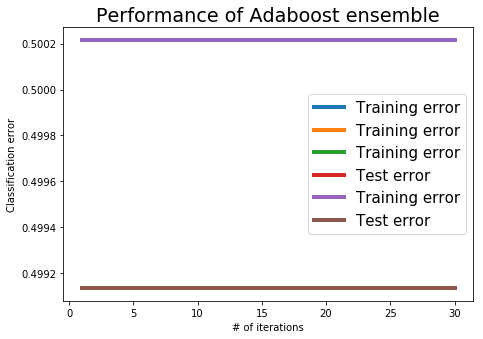

In [154]:
plt.show()
max_features=3, min_samples_leaf=40,n_estimators=15